In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [2]:
N_MODELS = 10

### Dataset

In [3]:
class MoTDataset(Dataset):
    def __init__(self, edge_index, rating):
        self.edge_index = edge_index
        self.rating = rating

    def __len__(self):
        return len(self.edge_index)

    def __getitem__(self, idx):
        return self.edge_index[idx], self.rating[idx]

In [4]:
def load_rating_df(path) -> pd.DataFrame:
    """Load the rating dataframe from the given path."""
    df = pd.read_csv(path)
    rating_df = df.Id.str.split("_", expand=True)
    rating_df.columns = ["user", "movie"]
    rating_df["rating"] = df.Prediction
    return rating_df


def compute_gdata(rating_df: pd.DataFrame, fraction=1.0):
    """Creates the PyTorch Geometric Data object from the rating information"""
    # subsample the dataframe
    if fraction < 1.0:
        rating_df = rating_df.sample(frac=fraction)
    # Create the user and movie indices
    users = rating_df["user"].apply(lambda x: int(x[1:]) - 1)
    movies = rating_df["movie"].apply(lambda x: int(x[1:]) - 1)
    # create edge_index
    edge_index = np.stack([users, movies], axis=1)
    rating = rating_df.rating.values
    # rating = np.ones_like(rating_df.rating.values)
    return MoTDataset(edge_index, rating)


In [5]:
train_df = load_rating_df("../data/cross_validation/train_split_0.csv")
test_df = load_rating_df("../data/cross_validation/test_split_0.csv")

# train_df = load_rating_df("../data/data_train.csv")

# create training and test data
train_datasets = [compute_gdata(train_df, 0.2) for _ in range(N_MODELS)]
full_train_dataset = compute_gdata(train_df, 1.0)
test_dataset = compute_gdata(test_df, 1.0)

# create test data loader
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

### Model

In [6]:
# Mixture of Tastes model
class MoT(nn.Module):
    def __init__(self, n_users, n_movies, n_tastes, n_components):
        super(MoT, self).__init__()
        self.n_tastes = n_tastes
        self.n_components = n_components

        self.softmax = nn.Softmax(dim=1)
        self.taste_embeddings = nn.Embedding(n_users, n_tastes*n_components)
        self.attention_embeddings = nn.Embedding(n_users, n_tastes*n_components)
        self.movie_embeddings = nn.Embedding(n_movies, n_components)
        self.movie_bias = nn.Embedding(n_movies, 1)
    
    def forward(self, edge):
        user_id = edge[:, 0]
        movie_id = edge[:, 1]
        A_i = self.attention_embeddings(user_id)
        A_i = A_i.view(-1, self.n_tastes, self.n_components)
        attention = self.softmax(torch.bmm(A_i, self.movie_embeddings(movie_id).unsqueeze(-1)))
        U_i = self.taste_embeddings(user_id)
        U_i = U_i.view(-1, self.n_tastes, self.n_components)
        rec_scores = torch.bmm(U_i, self.movie_embeddings(movie_id).unsqueeze(-1))
        y_hat = torch.sum(rec_scores * attention, dim=1) + self.movie_bias(movie_id)
        return y_hat.squeeze()

In [7]:
def loss(pred, edge_label):
    return rmse(pred, edge_label.float())

def rmse(pred, edge_label):
    return torch.sqrt(torch.mean((pred.float() - edge_label.float()) ** 2))

### Training

In [8]:
models = [MoT(n_users=10000, n_movies=1000, n_tastes=4, n_components=32) for _ in range(N_MODELS)]
opts = [Adam(model.parameters(), lr=np.exp(-6), weight_decay=np.exp(-11)) for model in models]
train_loaders = [DataLoader(train_dataset, batch_size=2**12, shuffle=True, drop_last=True) for train_dataset in train_datasets]

In [12]:
for model, opt, train_loader in tqdm(zip(models, opts, train_loaders), total=N_MODELS, desc="model", position=2):
    model.train()
    for epoch in tqdm(range(25), desc="epoch", leave=False, position=1):
        for edge, y in tqdm(train_loader, desc="batch", leave=False, position=0):
            opt.zero_grad()
            y_hat = model(edge)
            train_loss = loss(y_hat, y)
            train_rmse = rmse(torch.clip(y_hat, 1, 5), y)
            train_loss.backward()
            opt.step()

model:   0%|          | 0/10 [00:00<?, ?it/s]

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

batch:   0%|          | 0/45 [00:00<?, ?it/s]

In [13]:
models_y_hat = torch.stack([model(torch.tensor(full_train_dataset.edge_index)) for model in models], dim=0)

In [15]:
models_y_hat.T.shape

torch.Size([941561, 10])

In [24]:
weights = torch.linalg.lstsq(models_y_hat.T, torch.tensor(full_train_dataset.rating).float()).solution
weights

tensor([0.4135, 0.3384, 0.0633, 0.0612, 0.0626, 0.0643, 0.0618, 0.0640, 0.0662,
        0.0634], grad_fn=<LinalgLstsqBackward0>)

In [28]:
(models_y_hat.T @ weights - torch.tensor(full_train_dataset.rating).float()).square().mean().sqrt()

tensor(0.9693, grad_fn=<SqrtBackward0>)

In [33]:
sub_df = load_rating_df("../data/sampleSubmission.csv")
sub_dataset = compute_gdata(sub_df)

In [34]:
sub_y_hats = torch.stack([model(torch.tensor(sub_dataset.edge_index)) for model in models], dim=0)
sub_y_hat = torch.clip(sub_y_hats.T @ weights, 1, 5).detach()

<AxesSubplot:ylabel='Count'>

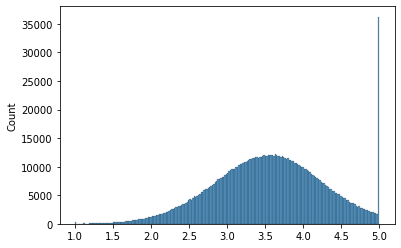

In [35]:
sns.histplot(sub_y_hat)

In [ ]:
submission = pd.read_csv("../data/sampleSubmission.csv")
submission["Prediction"] = sub_y_hat.numpy()
submission.to_csv("../data/submission-mot_ensemble.csv", index=False)